In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from CRR import MimoConformalRidgeRegressor
rnd_gen = np.random.default_rng(2024)

In [2]:
num_test_steps = 24 * 7 * 5

fh = 5

url_file = (
    "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/"
    "examples/data/demand_temperature.csv"
)
demand_df = pd.read_csv(
    url_file, parse_dates=True, index_col=0
)
# demand_df['Demand'] = (demand_df.Demand - demand_df.Demand.min()) / (demand_df.Demand.max() - demand_df.Demand.min()) # Min/max scale
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour
n_lags = 24
for hour in range(1, n_lags):
    demand_df[f"Lag_{hour}"] = demand_df["Demand"].shift(hour)
for hour in range(1, fh):
    demand_df[f"Pre_{hour}"] = demand_df["Demand"].shift(-hour)
    # Comment out below to skip tempereature "forecast"
    # demand_df[f"TempForecast_{hour}"] = demand_df["Demand"].shift(-hour) + rnd_gen.normal(0, 3)
demand_df = demand_df.dropna()
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
features = ["Weekofyear", "Weekday", "Hour", "Temperature"]
features += [f"Lag_{hour}" for hour in range(1, n_lags)]
# features += [f"TempForecast_{hour}" for hour in range(1, fh)]
targets = ['Demand']
targets += [f"Pre_{hour}" for hour in range(1, fh)]

X_train = demand_train.loc[
    ~np.any(demand_train[features].isnull(), axis=1), features
]
y_train = demand_train.loc[X_train.index, targets]
X_test = demand_test.loc[:, features]
y_test = demand_test[targets]

X = demand_df[features]
y = demand_df[targets]

initial_window_size = y_train.shape[0]

X = X.values
y = y.values#.flatten()

# X = demand_df.Temp.values.reshape(-1,1)
# y = demand_df.y.values

# demand_df.corr()

y.shape

(1317, 5)

In [5]:
initial_training_size = int(X.shape[0]//2)

X_train = X[:initial_training_size]
y_train = y[:initial_training_size]

X_run = X[initial_training_size:]
y_run = y[initial_training_size:]

In [6]:
cp = MimoConformalRidgeRegressor(h=fh)

cp.learn_initial_training_set(X_train[:-1], y_train[:-1])

Err = np.zeros(fh) # Record error at each hour

for i, (obj, label) in enumerate(zip(X_run, y_run)):
    # Reality presents the object x
    x = obj
    # Forecaster outputs Gamma
    Gamma = cp.predict(x, epsilon=0.1, bounds='both')
    width = cp.width(Gamma)
    # Reality presents the label
    cp.learn_one(x, label) 
    err = cp.err(Gamma, label) # This is not realistic. We have to wait to get the true labels. 
    Err += err

In [7]:
Err/(i+1)

array([0.12898331, 0.12746586, 0.12746586, 0.12746586, 0.12746586])

In [5]:
Err/(i+1)

array([0.12898331, 0.10318665, 0.08649469, 0.07132018, 0.07435508])

In [5]:
cp.y

array([[4.001, 3.623, 3.249, 3.047, 3.004],
       [3.623, 3.249, 3.047, 3.004, 3.104],
       [3.249, 3.047, 3.004, 3.104, 3.361],
       ...,
       [5.272, 5.441, 5.535, 5.534, 5.61 ],
       [5.441, 5.535, 5.534, 5.61 , 5.671],
       [5.535, 5.534, 5.61 , 5.671, 5.724]])

In [54]:
X_train[-2][-23:]

array([5.272, 4.626, 4.06 , 3.873, 3.955, 4.148, 4.484, 5.052, 5.026,
       5.611, 6.481, 7.214, 8.174, 8.889, 9.198, 9.103, 8.825, 8.522,
       8.185, 7.796, 7.381, 6.941, 6.487])

In [55]:
X_train[-1][-23:]

array([5.441, 5.272, 4.626, 4.06 , 3.873, 3.955, 4.148, 4.484, 5.052,
       5.026, 5.611, 6.481, 7.214, 8.174, 8.889, 9.198, 9.103, 8.825,
       8.522, 8.185, 7.796, 7.381, 6.941])

In [58]:
y_train[-4]

array([4.626, 5.272, 5.441, 5.535, 5.534])

In [36]:
y_train[-1]

array([5.535, 5.534, 5.61 , 5.671, 5.724])

In [39]:
cp.y[-2]

array([5.441, 5.535, 5.534, 5.61 , 5.671])

In [41]:
np.allclose(cp.y, y_train)

True

In [12]:
Err

array([14., 34., 34., 44., 46.])

Text(0.5, 1.0, 'CRR')

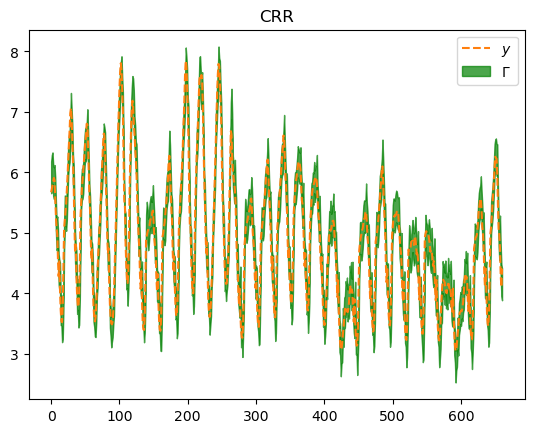

In [9]:
from CRR import ConformalRidgeRegressor

cp = ConformalRidgeRegressor(a=1, autotune=True)

cp.learn_initial_training_set(X_train, y_train)

Err = 0

predictions = np.empty((X_run.shape[0], 5))
for i, (obj, label) in enumerate(zip(X_run, y_run)):
    # Reality presents the object x
    x = obj
    # Forecaster outputs Gamma
    Gamma = cp.predict(x, epsilon=0.1, bounds='both')
    width = cp.width(Gamma)
    # Reality presents the label
    cp.learn_one(x, label)  
    err = cp.err(Gamma, label)
    Err += err
    predictions[i, 0] = Gamma[0] # Lower 
    predictions[i, 1] = Gamma[1] # Upper 
    predictions[i, 2] = err # Error
    predictions[i, 3] = label # True label
    predictions[i, 4] = width # True label


plt.plot(y_run, label=r'$y$', color='C1', linestyle='--')
plt.fill_between(
    x=[i for i, _ in enumerate(y_run)],
    y1=predictions[:,0],
    y2=predictions[:,1],
    label=r'$\Gamma$',
    color='green',
    alpha=0.7,
)
plt.legend()
plt.title('CRR')